_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [71]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [72]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [73]:
df.tail()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0
13957,41800403,658,Stephen Curry,4,2,47,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24,-226,104,0,2019-06-05,GSW,TOR,Playoffs,-12.0


In [74]:
#baseline 
df['shot_made_flag'].value_counts()

0    7357
1    6601
Name: shot_made_flag, dtype: int64

In [75]:
df['game_date'].dtypes
df['dtf'] = pd.to_datetime(df['game_date'])

In [76]:
#get the test set for 2018-2019 season
tp1 = df[((df['dtf'].dt.year >= 2018) & (df['dtf'].dt.month >=10))]
tp2 = df[df['dtf'].dt.year == 2019]
print(tp1.shape, tp2.shape)
test = pd.concat([tp1, tp2])
print(test.shape)

(526, 21) (1183, 21)
(1709, 21)


In [77]:
#get the train set for the rest of the values
tt1 = df[(df['dtf'].dt.year == 2018) & (df['dtf'].dt.month<10)]
tt2 = df[df['dtf'].dt.year < 2018]
print(tt1.shape, tt2.shape)
train = pd.concat([tt1, tt2])
print(train.shape)

(745, 21) (11504, 21)
(12249, 21)


In [78]:
#make sure no data was lost in split
print(train.shape, test.shape)
print(len(df))
len(df) == len(train) + len (test)

(12249, 21) (1709, 21)
13958


True

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [79]:
#engineer a feature for seconds remaining in period
#basically minutes * 60 plus seconds
train['remaining_secs_in_period'] = (train['minutes_remaining'] * 60) + train['seconds_remaining']
test['remaining_secs_in_period'] = (test['minutes_remaining'] * 60) + test['seconds_remaining']
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,dtf,remaining_secs_in_period
11504,21700562,39,Stephen Curry,1,8,43,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),...,-222,52,0,2018-01-03,DAL,GSW,Regular Season,-0.0,2018-01-03,523
11505,21700562,44,Stephen Curry,1,8,18,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),...,90,285,1,2018-01-03,DAL,GSW,Regular Season,-0.0,2018-01-03,498
11506,21700562,48,Stephen Curry,1,7,50,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),...,-150,204,0,2018-01-03,DAL,GSW,Regular Season,-0.0,2018-01-03,470
11507,21700562,95,Stephen Curry,1,5,11,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side(R),...,119,52,1,2018-01-03,DAL,GSW,Regular Season,-1.0,2018-01-03,311
11508,21700562,123,Stephen Curry,1,3,11,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,-86,25,1,2018-01-03,DAL,GSW,Regular Season,4.0,2018-01-03,191


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [59]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.8, random_state=42)
print(train.shape, val.shape)

(9799, 21) (2450, 21)


In [80]:
#select features
todrop = ['shot_made_flag', 'dtf']
featureset = train.drop(columns = todrop)
features = featureset.columns.tolist()
print(features)

['game_id', 'game_event_id', 'player_name', 'period', 'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y', 'game_date', 'htm', 'vtm', 'season_type', 'scoremargin_before_shot', 'remaining_secs_in_period']


In [81]:
target = 'shot_made_flag'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [82]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators = 20, random_state=42)
        
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'game_date', 'htm',
                                      'vtm', 'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dty...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
               

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [83]:
print('Validation Accuracy: ', pipeline.score(X_val, y_val))

Validation Accuracy:  0.8979591836734694


## 7. Get your model's test accuracy

> (One time, at the end.)

In [84]:
print('Test Accuracy: ', pipeline.score(X_test, y_test))

Test Accuracy:  0.5740198946752487


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [85]:
correct_predictions = 85 + 36
total_predictions = 85 + 58 + 8 + 36
accuracy = correct_predictions / total_predictions
print('Accuracy: ', accuracy)

Accuracy:  0.6470588235294118


### Calculate precision

In [87]:
positive_correct = 36
positive_incorrect = 58
positive_precision = positive_correct / (positive_incorrect + positive_correct)
negative_correct = 85
negative_incorrect = 8
negative_precision = negative_correct / (negative_incorrect + negative_correct)
print('Positive Prediction Precision: ', positive_precision)
print('Negative Prediction Precision: ', negative_precision)

Positive Prediction Precision:  0.3829787234042553
Negative Prediction Precision:  0.9139784946236559


### Calculate recall

In [88]:
positive_recall = positive_correct / (positive_correct + negative_incorrect)
negative_recall = negative_correct / (negative_correct + positive_incorrect)
print('Positive Recall: ', positive_recall)
print('Negative Recall: ', negative_recall)

Positive Recall:  0.8181818181818182
Negative Recall:  0.5944055944055944


### Find Feature Importances

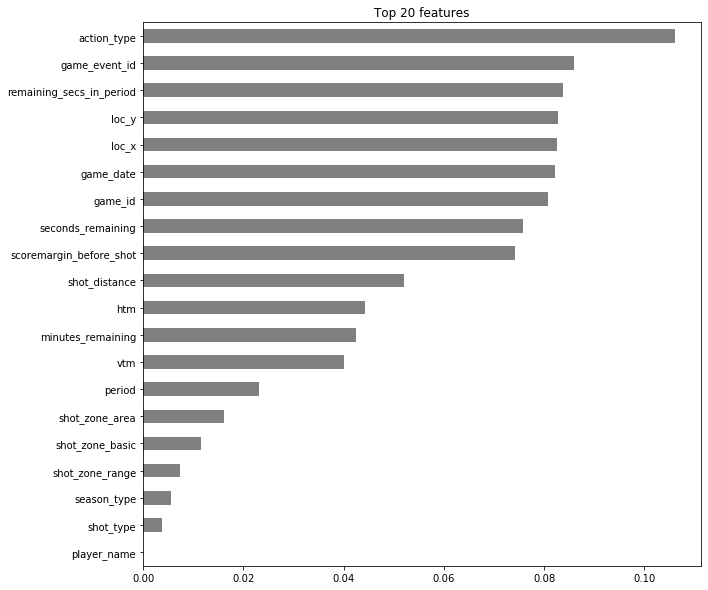

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Plot features and target

In [96]:
import plotly.express as px
px.scatter(train, x='loc_x', y='loc_y', color='shot_made_flag')

In [103]:
df['shot_type'].value_counts()

2PT Field Goal    7135
3PT Field Goal    6823
Name: shot_type, dtype: int64

In [109]:
#work in progress
# twopointers = df['shot_type'] == '2PT Field Goal'
# tpts = df[df['shot_made_flag'] == twopointers]
# tpts.head()

<BarContainer object of 12249 artists>

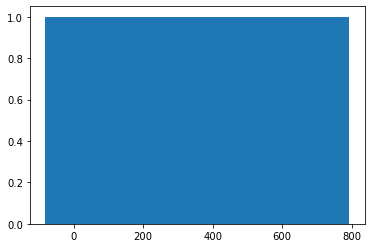

In [100]:
plt.bar(train['remaining_secs_in_period'], train['shot_made_flag'])